In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../')

In [2]:
from ConformalMethods import AdaptiveCP, ACP_data, ACP_plots

## Our adaptive look back functions.

In [3]:
def scale_C_t(scale, alpha_t, scores, sigma_t, t, interval=50):
    alpha_t = min(1, max(0, alpha_t))
    Q = np.quantile(scores[t-interval:t], 1 - alpha_t)
    positve_v = (sigma_t) + scale *(abs(sigma_t) * Q)
    negative_v = (sigma_t) - scale *(abs(sigma_t) * Q)
    return negative_v, positve_v

def err_t(Y_t, C_t):
    if C_t[0] < Y_t < C_t[1]:
        return 0
    else:
        return 1

In [4]:
def scaled_ACI(coverage_target: float, timeseries_data: tuple, gamma: float, custom_interval: int) -> dict:
    xpred, y = timeseries_data
    alpha_t_list = [coverage_target]

    All_scores = (abs(y - xpred))/abs(xpred)

    err_t_list = []
    conformal_sets_list = []
    
    error_counter = 0
    for i in range(custom_interval+1, len(All_scores)):
        look_back = min(max(3, custom_interval - 2*error_counter), i)
        scale = 1 + (custom_interval - look_back)/custom_interval

        Coverage_t = scale_C_t(scale, alpha_t_list[-1], All_scores, xpred[i], i, look_back)
        conformal_sets_list.append(Coverage_t)

        error_t = err_t(y[i], Coverage_t)
        err_t_list.append(error_t)


        if error_t:
                error_counter+=1
        else:
            error_counter = max(-3, error_counter-1)

        

    # Calculating different averages
    realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(custom_interval).mean().mean()
    average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

    return {
        'model': 'scaled_ACI',
        'coverage_target': coverage_target,
        'gamma': gamma,
        'realised_interval_coverage': realised_interval_coverage,
        'alpha_t_list': alpha_t_list,
        'average_prediction_interval': average_prediction_interval,
        'conformal_sets': conformal_sets_list,
        'error_t_list': err_t_list, 
        'interval_size': custom_interval
    }

With parameter_lookback_neg, can edit the minum and maximum the look back can be and how fast it corrects after making a change.

In [5]:
def parameter_lookback_upneg(coverage_target: float, timeseries_data: tuple, mu: int, sigma: float, delta: float, custom_interval: int) -> dict:
    xpred, y = timeseries_data
    alpha_t_list = [coverage_target]
    All_scores = (abs(y - xpred))/abs(xpred)

    err_t_list = []
    conformal_sets_list = []
    interval_list = []
    scale_list = []

    error_counter = 0

    for i in range(custom_interval+1, len(All_scores)):
        # Look back window
        look_back = min(max(round(mu), round(custom_interval - error_counter)), i)
        interval_list.append(look_back)

        scale = 1 + (custom_interval - look_back)/custom_interval
        scale_list.append(scale)

        Coverage_t = scale_C_t(scale, alpha_t_list[-1], All_scores, xpred[i], i, look_back)
        conformal_sets_list.append(Coverage_t)

        error_t = err_t(y[i], Coverage_t)
        err_t_list.append(error_t)

        if error_t:
                error_counter+=sigma
        else:
            error_counter = max(0, error_counter- delta*sigma)

    # Calculating different averages
    realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(custom_interval).mean().mean()
    average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

    return {
        'model': 'scaled_ACI_upneg',
        'coverage_target': coverage_target,
        'realised_interval_coverage': realised_interval_coverage,
        'alpha_t_list': alpha_t_list,
        'average_prediction_interval': average_prediction_interval,
        'conformal_sets': conformal_sets_list,
        'error_t_list': err_t_list, 
        'interval_list': interval_list,
        'scale_list': scale_list,
        'interval_size': custom_interval
    }

# The box plot funtion

In [6]:
def plot_box_plots(all_data, coverage_target, limit=10):
    interval = 100
    ACP = AdaptiveCP(coverage_target, interval)

    for i, data in enumerate(all_data):
        ACI = ACP.ACI(data, 0.1)
        Nadaptive = ACP.NonAdaptive(data)
        PLB = parameter_lookback_upneg(coverage_target, data, 5, 1, 0.5, interval)

        aci_interval = np.array([abs(x[1] - x[0]) for x in ACI['conformal_sets']])
        nadaptive_interval = np.array([abs(x[1] - x[0]) for x in Nadaptive['conformal_sets']])
        plb_interval = np.array([abs(x[1] - x[0]) for x in PLB['conformal_sets']])

        fig = plt.figure()

        # Create an axes instance
        ax = fig.add_subplot(111)

        # Create the boxplots
        ax.boxplot([aci_interval, nadaptive_interval, plb_interval])

        # add labels
        ax.set_xticklabels(['ACI', 'Non-Adaptive', 'PLB'])

        # Show the plot
        plt.show()

        if i == limit:
            break


# Generating the data

Want to see how the intervals behave on a dataset where the distribution does not change.

In [7]:
simple_dataloader = ACP_data(100, 1200, dist_shifts=[(0,1)], time_series_scale=0) 
no_shift_data = simple_dataloader.generate()

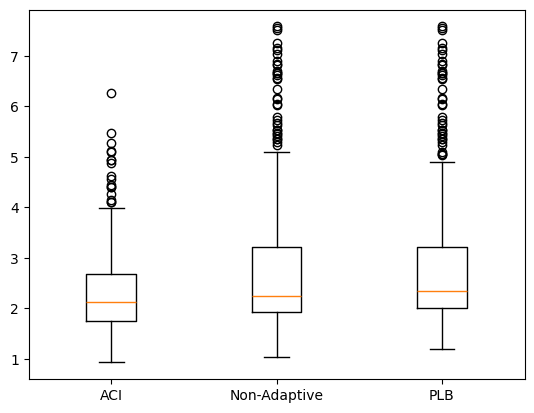

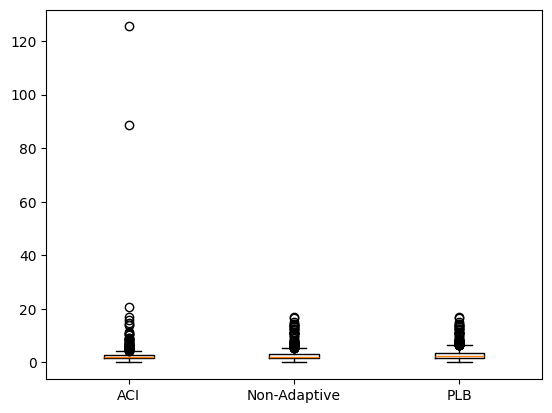

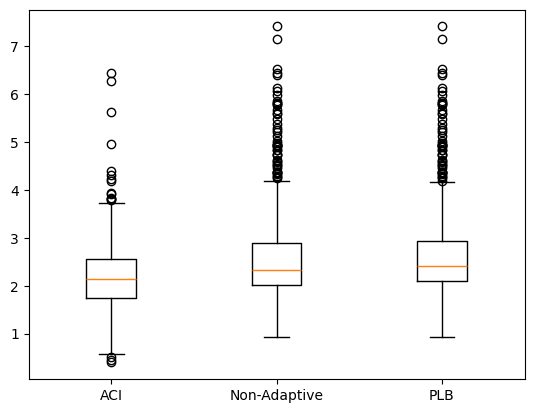

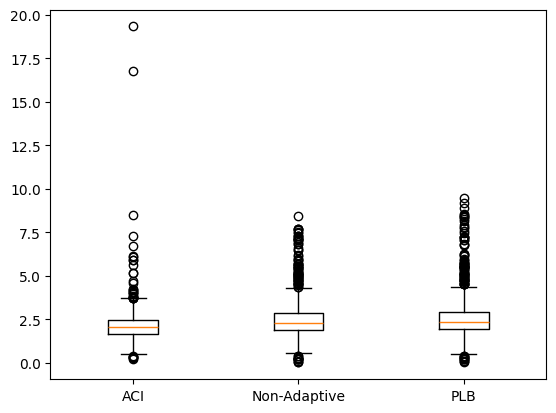

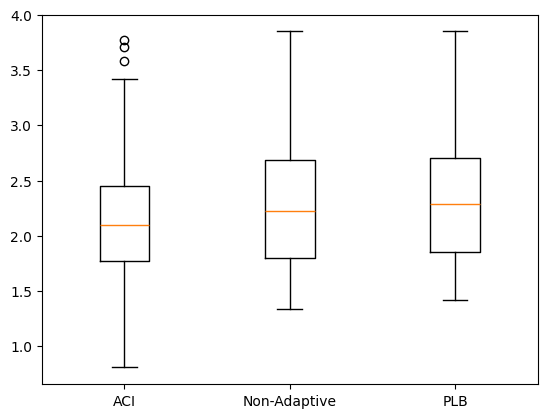

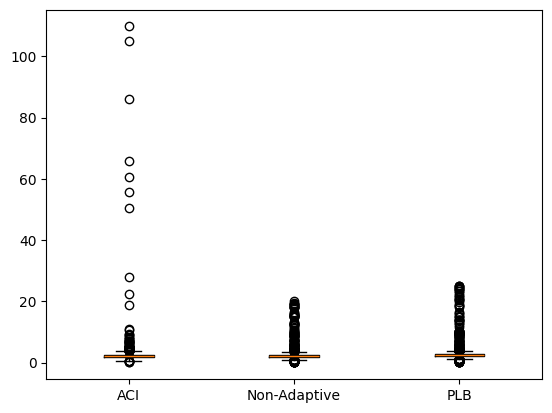

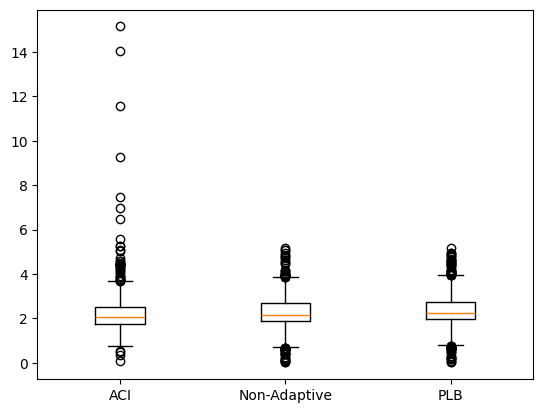

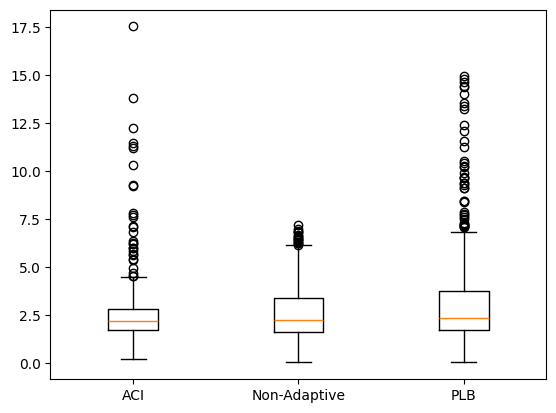

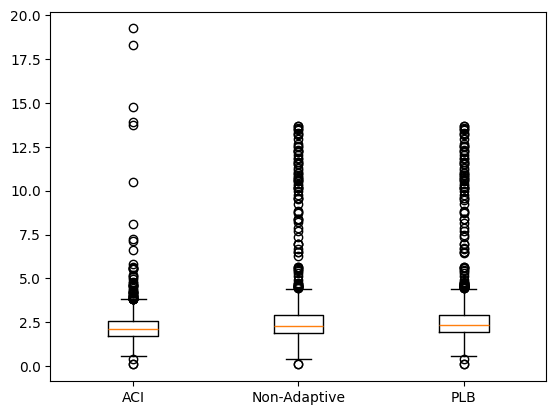

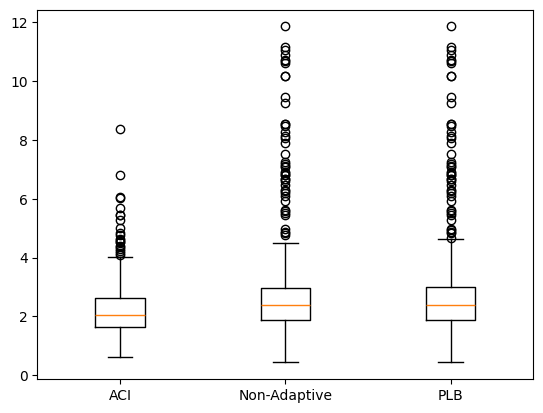

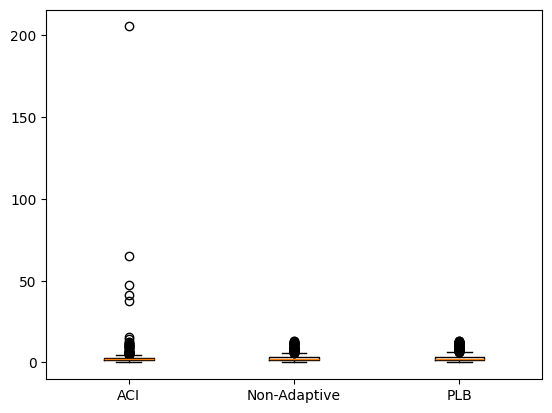

In [8]:
plot_box_plots(no_shift_data, 0.3, 10)

In [9]:
coverage_target = 0.3
ACP = AdaptiveCP(coverage_target)

def Plot_Box_plots(all_data, limit=10):
    for i, data in enumerate(all_data):
        ACI = ACP.ACI(data, 0.1)
        Nadaptive = ACP.NonAdaptive(data)
        PLB = parameter_lookback_upneg(coverage_target, data, 5, 1, 0.5, 50)

        aci_interval = np.array([abs(x[1] - x[0]) for x in ACI['conformal_sets']])
        nadaptive_interval = np.array([abs(x[1] - x[0]) for x in Nadaptive['conformal_sets']])
        plb_interval = np.array([abs(x[1] - x[0]) for x in PLB['conformal_sets']])

        fig = plt.figure()

        # Create an axes instance
        ax = fig.add_subplot(111)

        # Create the boxplots
        ax.boxplot([aci_interval, nadaptive_interval, plb_interval])

        # add labels
        ax.set_xticklabels(['ACI', 'Non-Adaptive', 'PLB'])

        # Show the plot
        plt.show()

        if i == limit:
            break


Want to see how it performs on a single distribution shift

In [10]:
two_dataloader = ACP_data(100, 1200, dist_shifts=[(0,1), (-1, 2)], time_series_scale=0) 
two_shift_data = two_dataloader.generate()

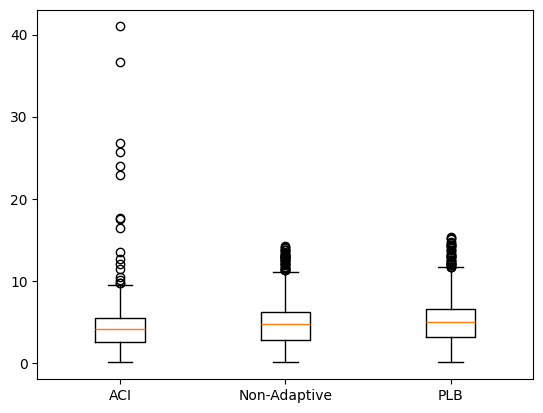

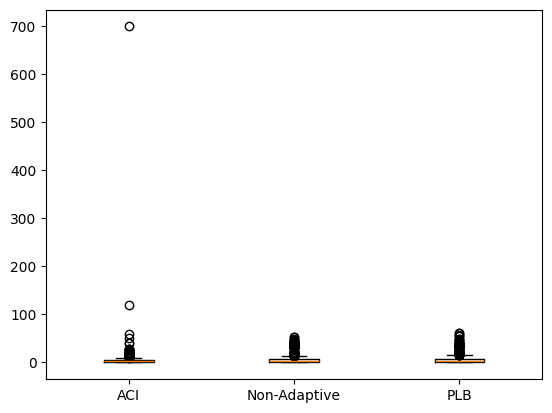

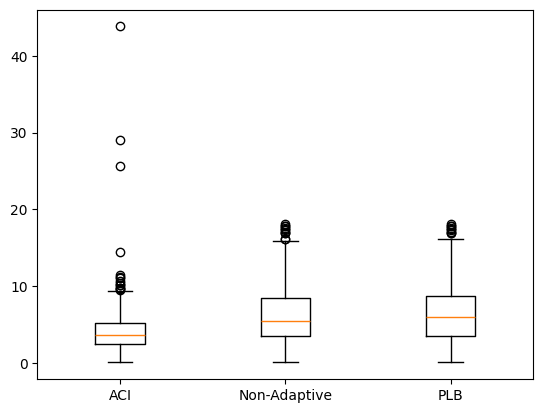

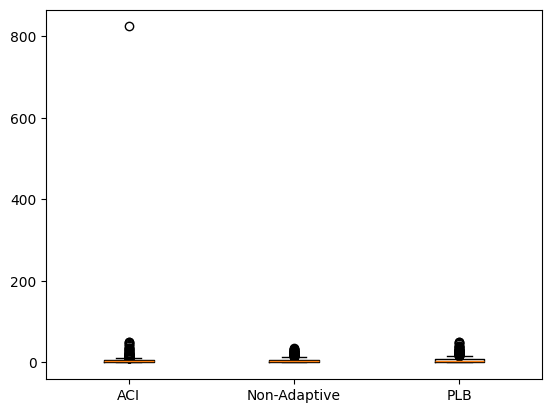

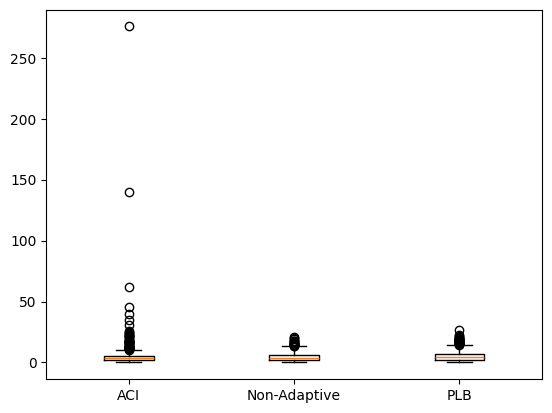

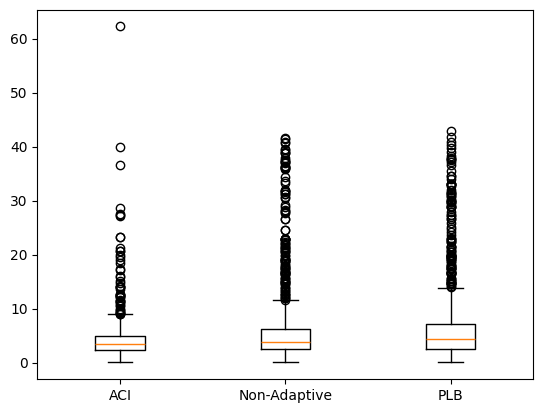

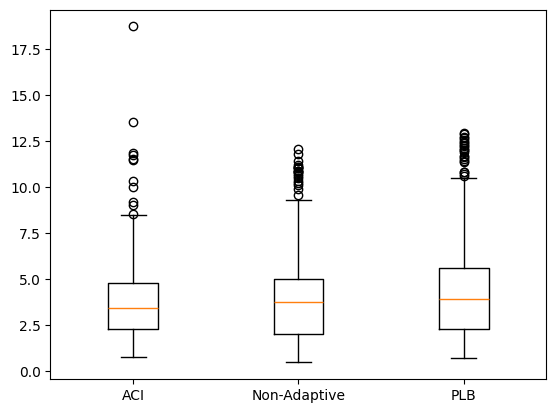

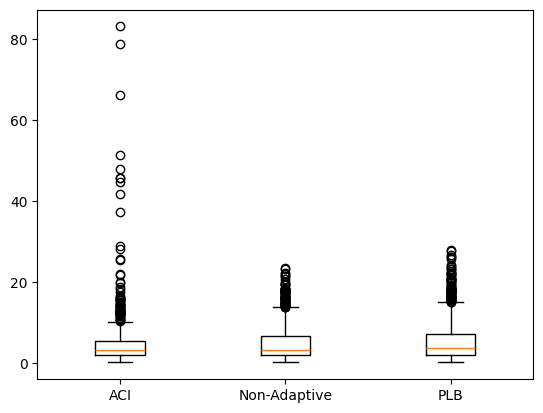

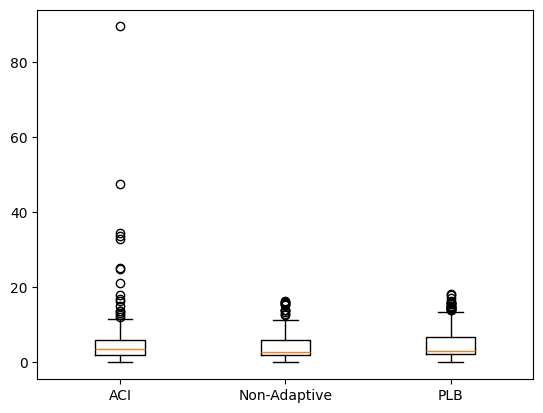

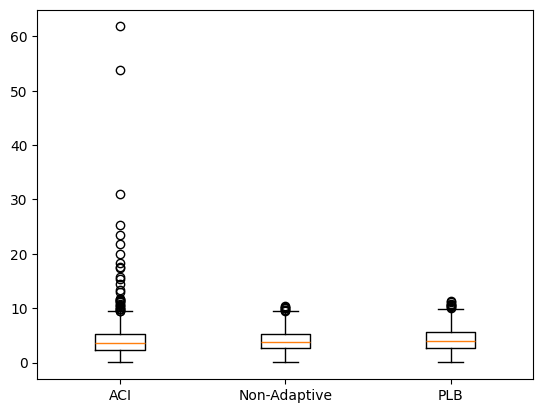

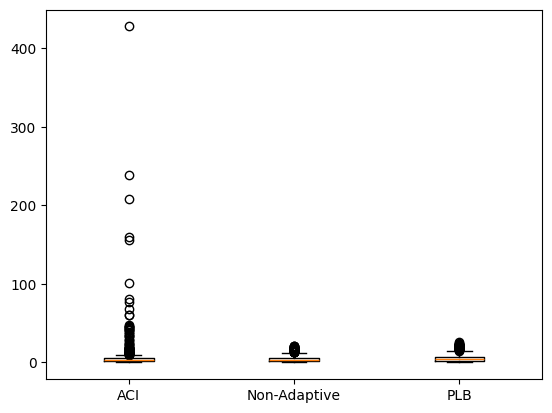

In [11]:
plot_box_plots(two_shift_data, 0.3, 10)

Okay the boxplots are acctualy useless, it will be more useful to understand how the intervals change based on the look back window. Make a very simple distribution which has one jump in it, then plot many different non-adaptive methods with different lookback windows. and see how they compare.

10
50
399 348 348


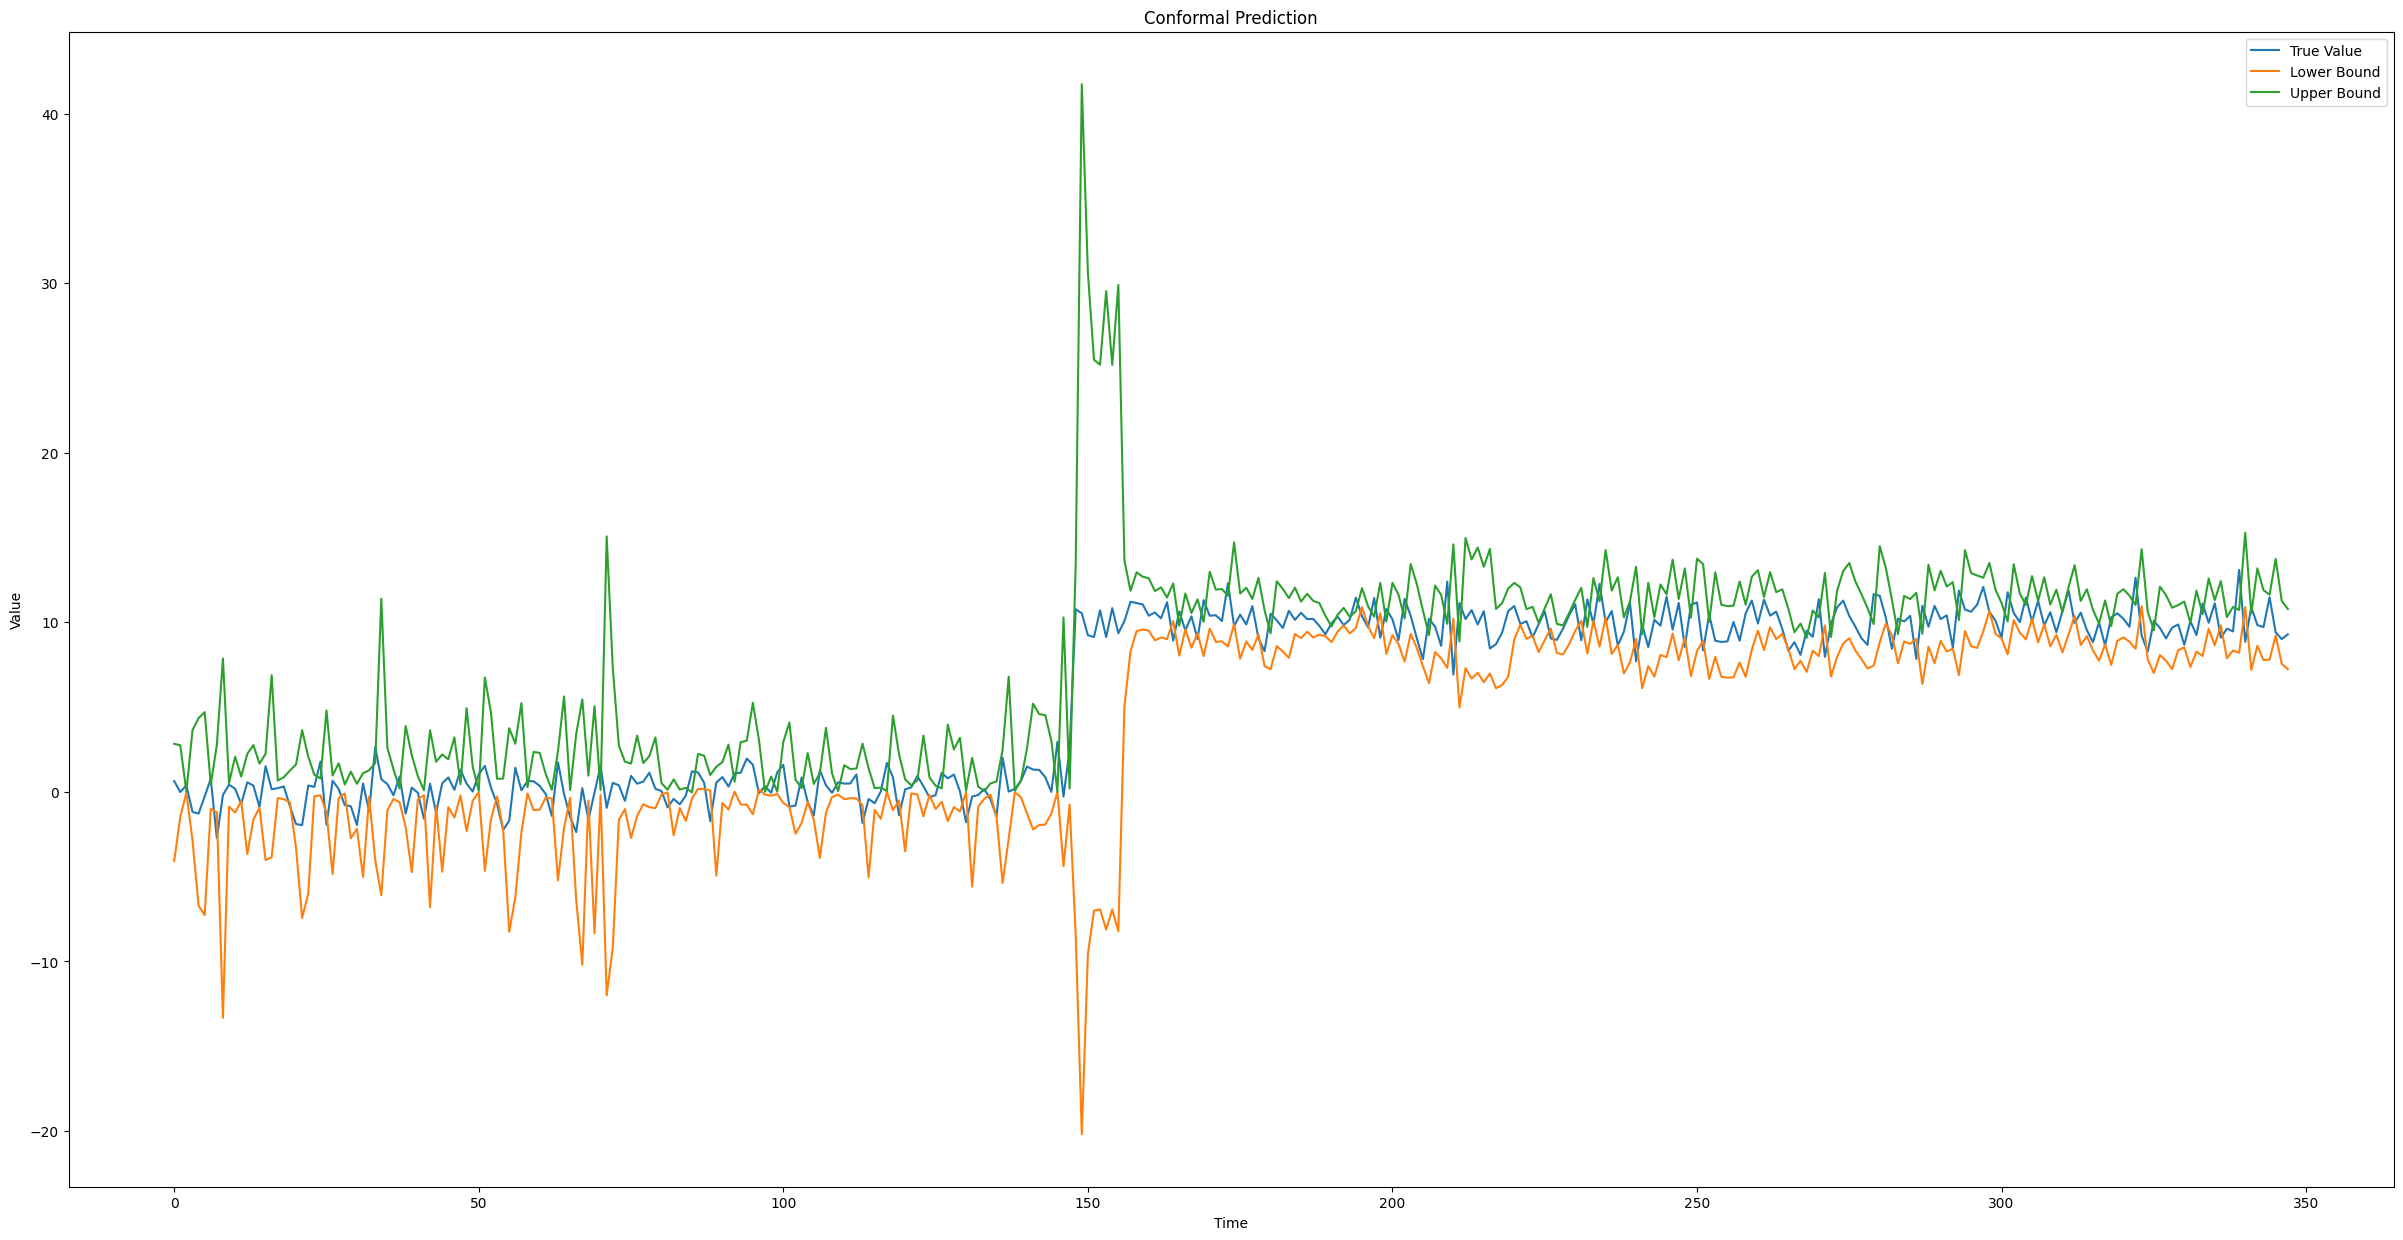

20
50
399 348 348


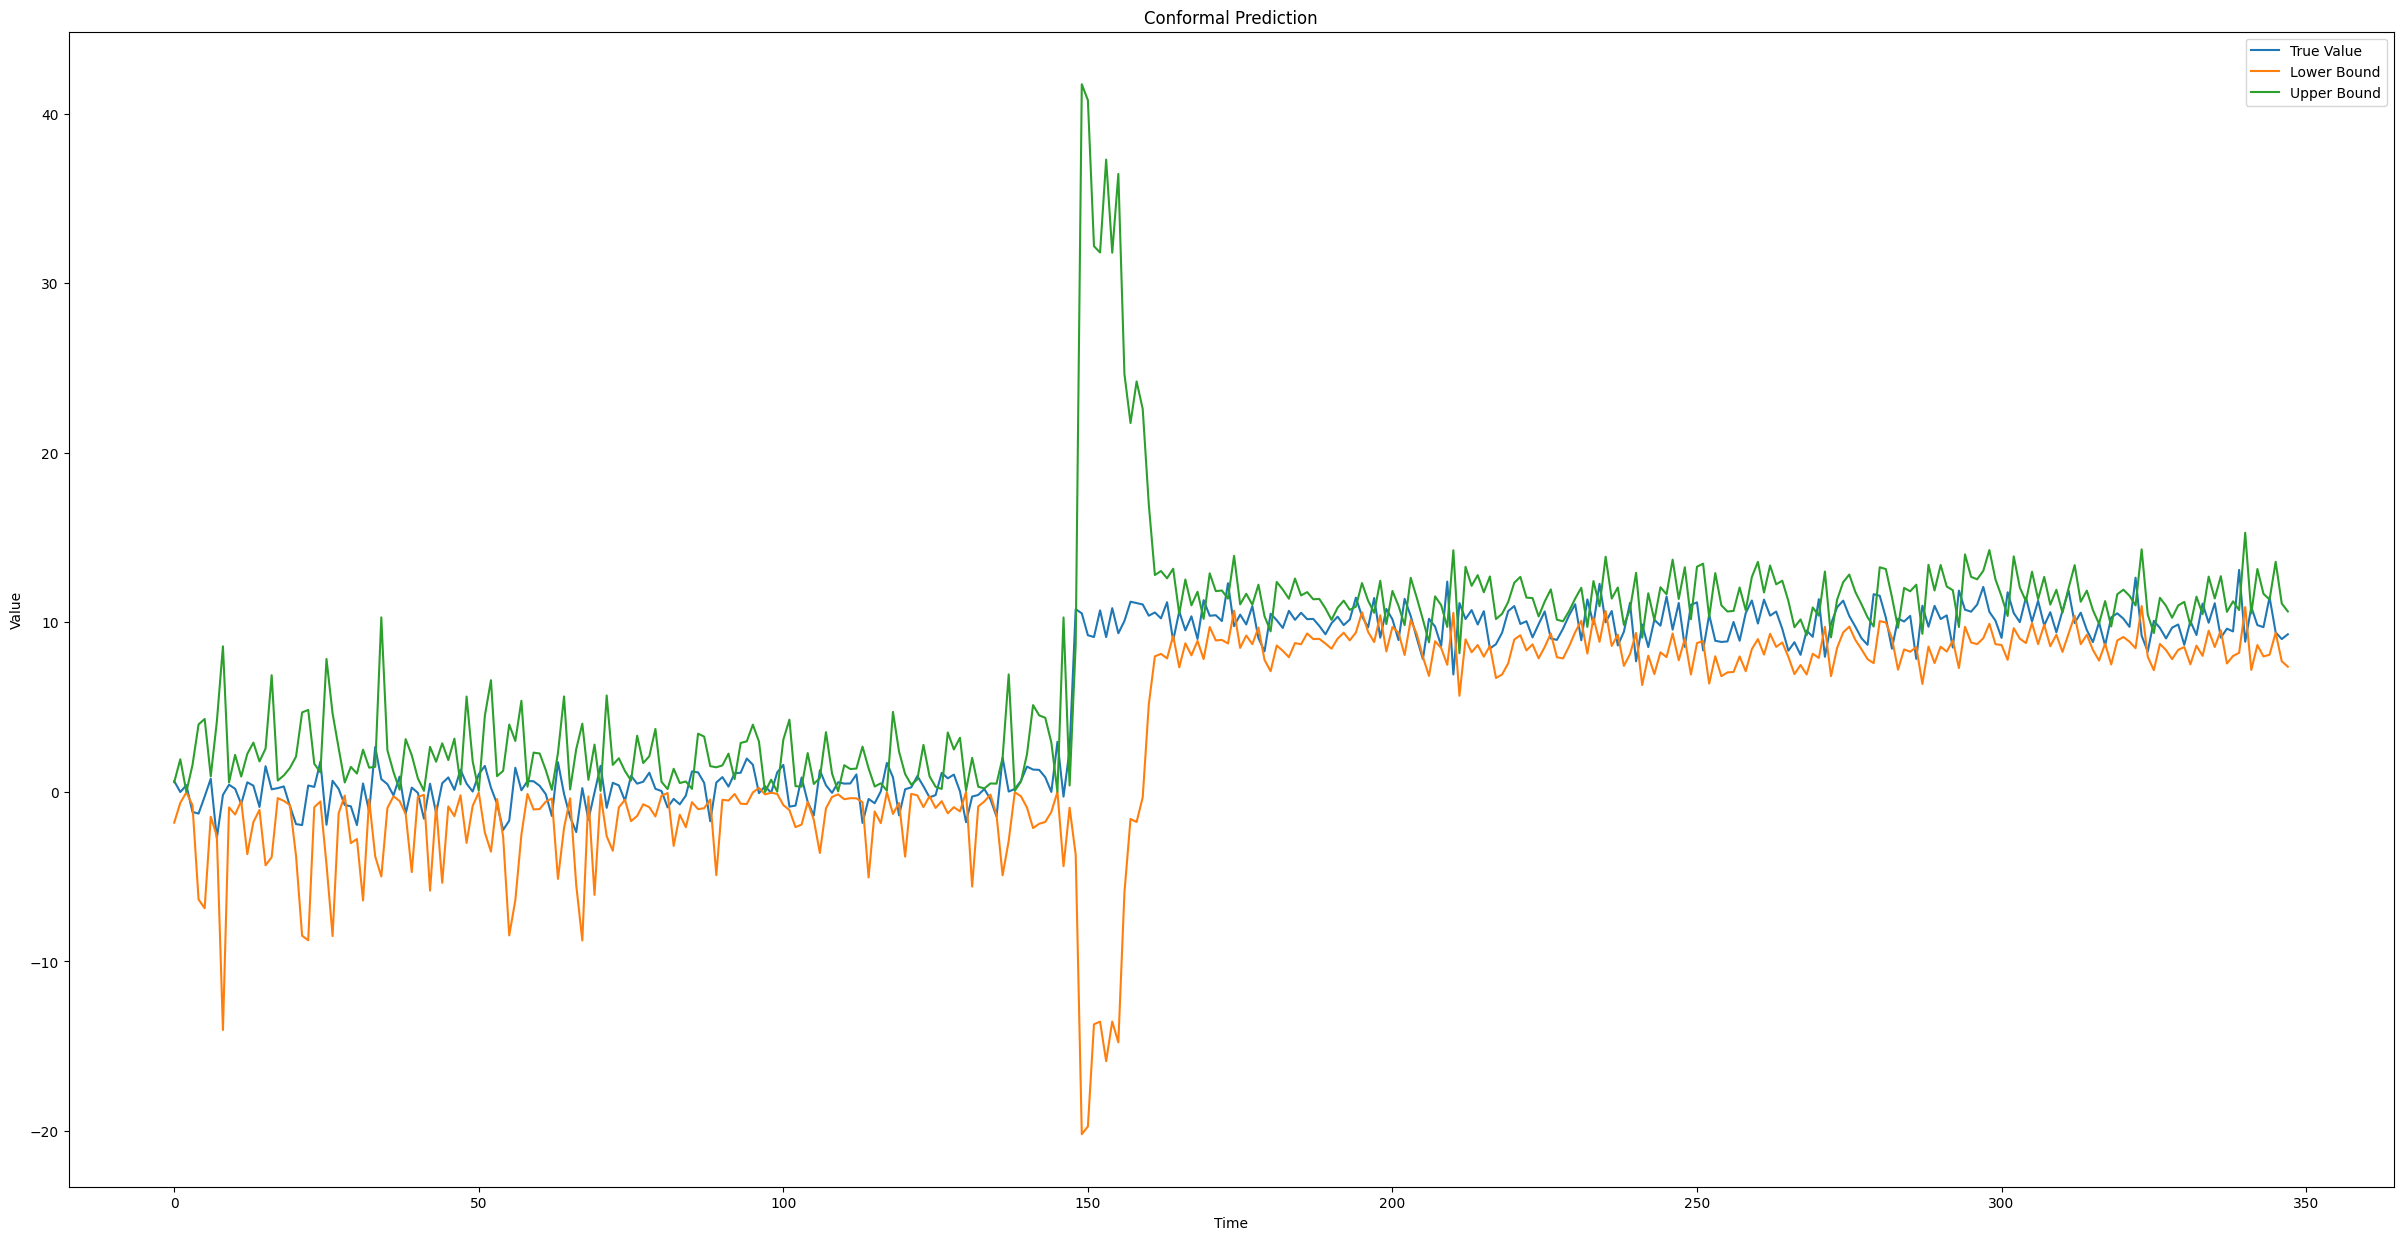

30
50
399 348 348


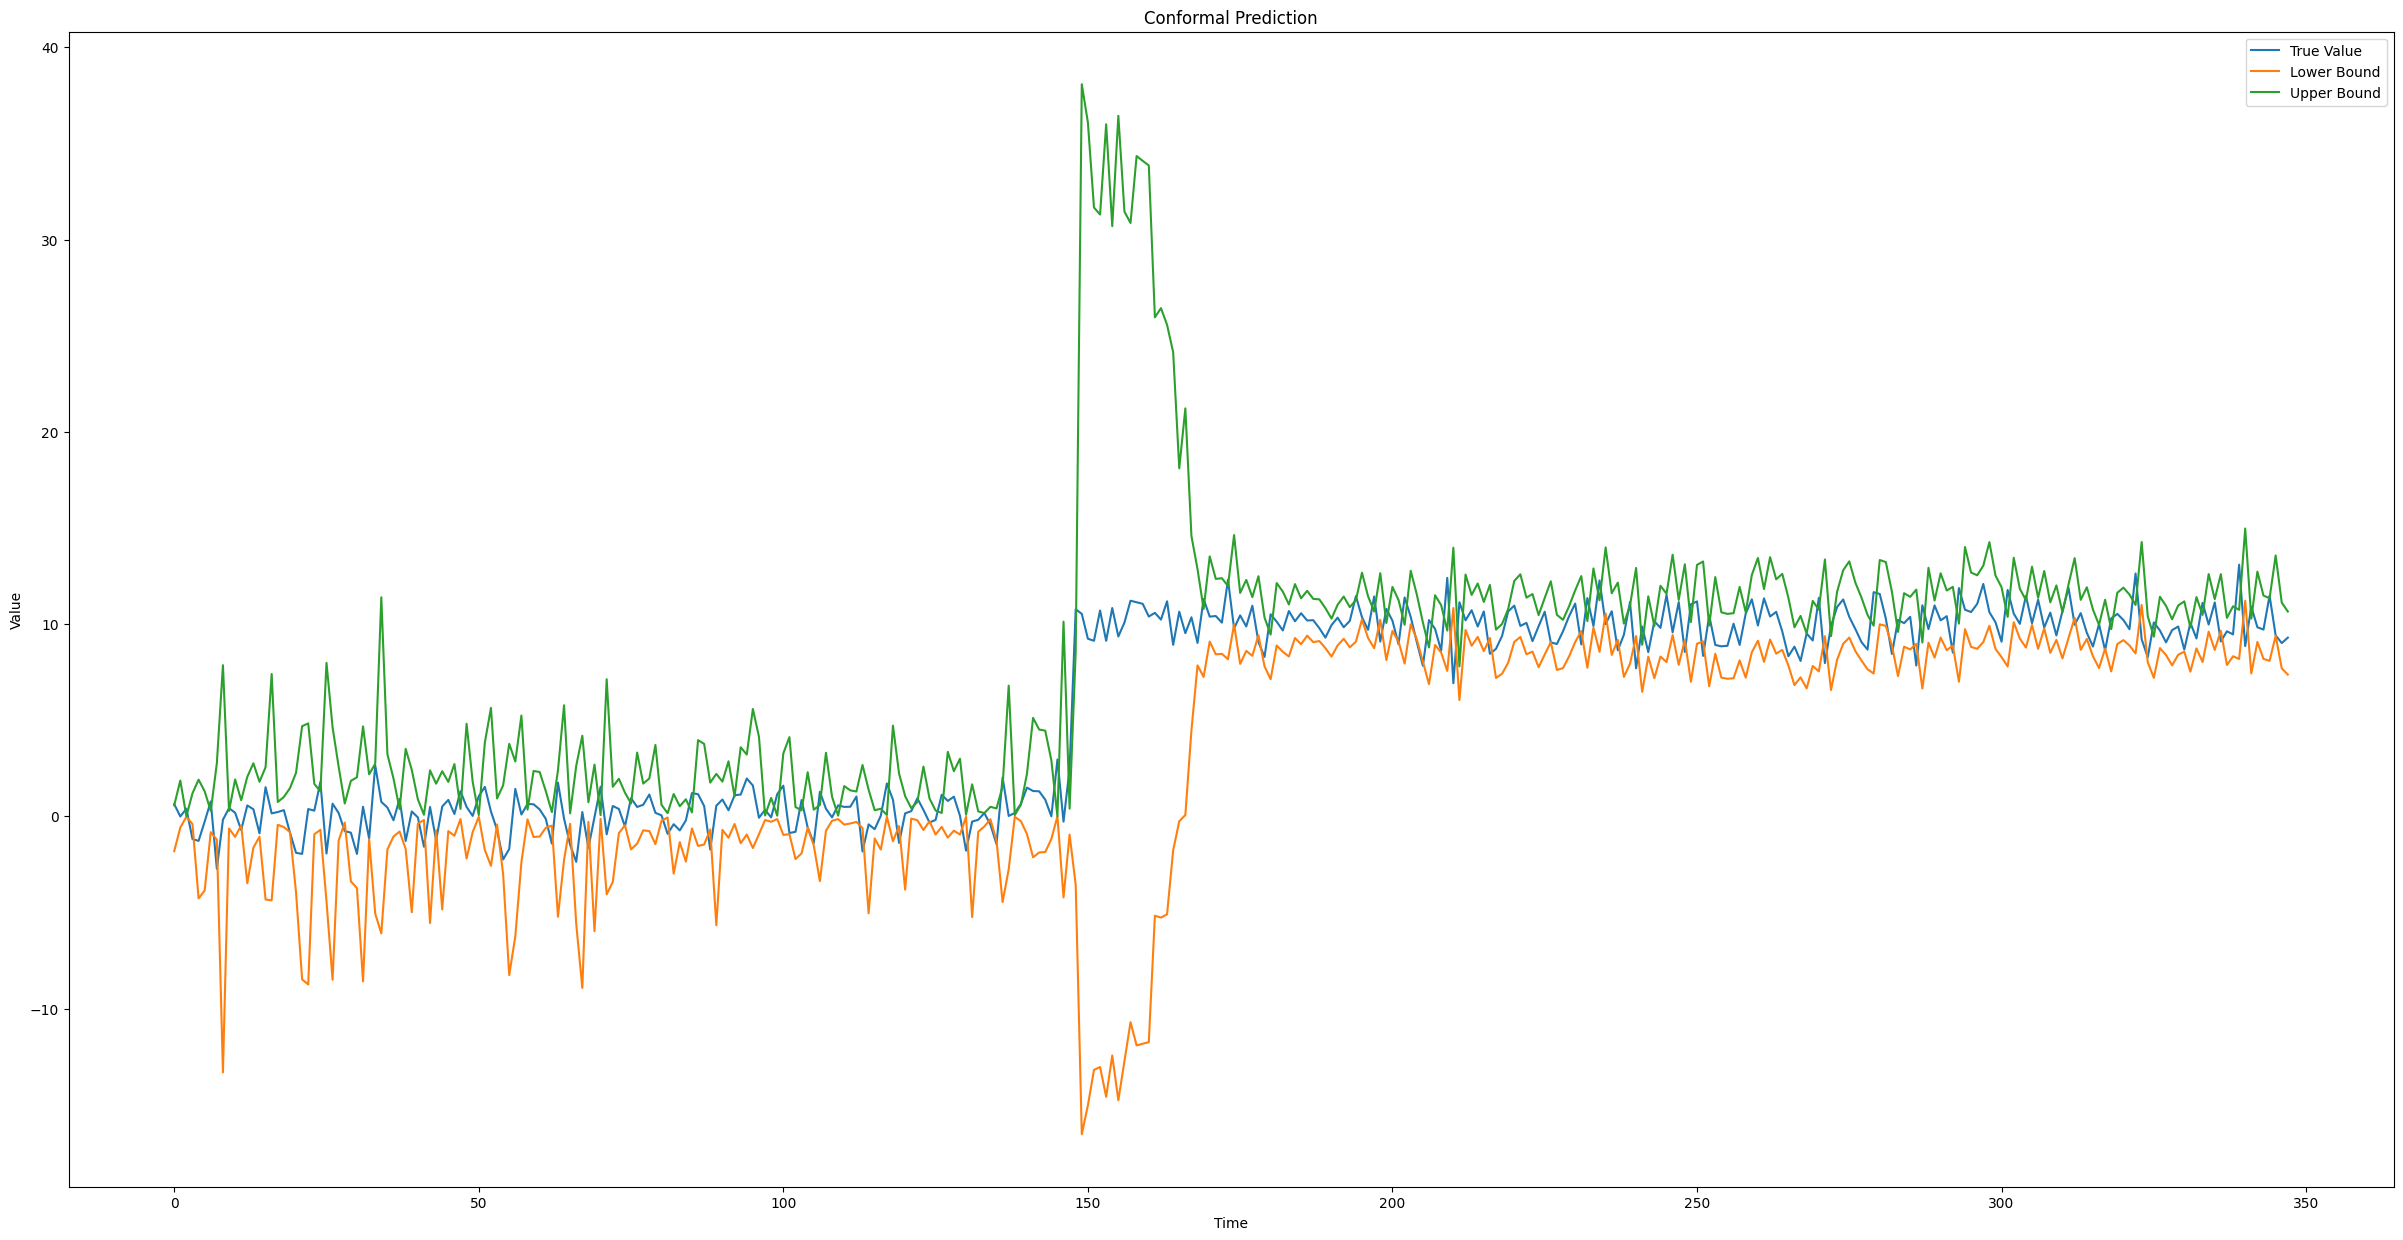

40
50
399 348 348


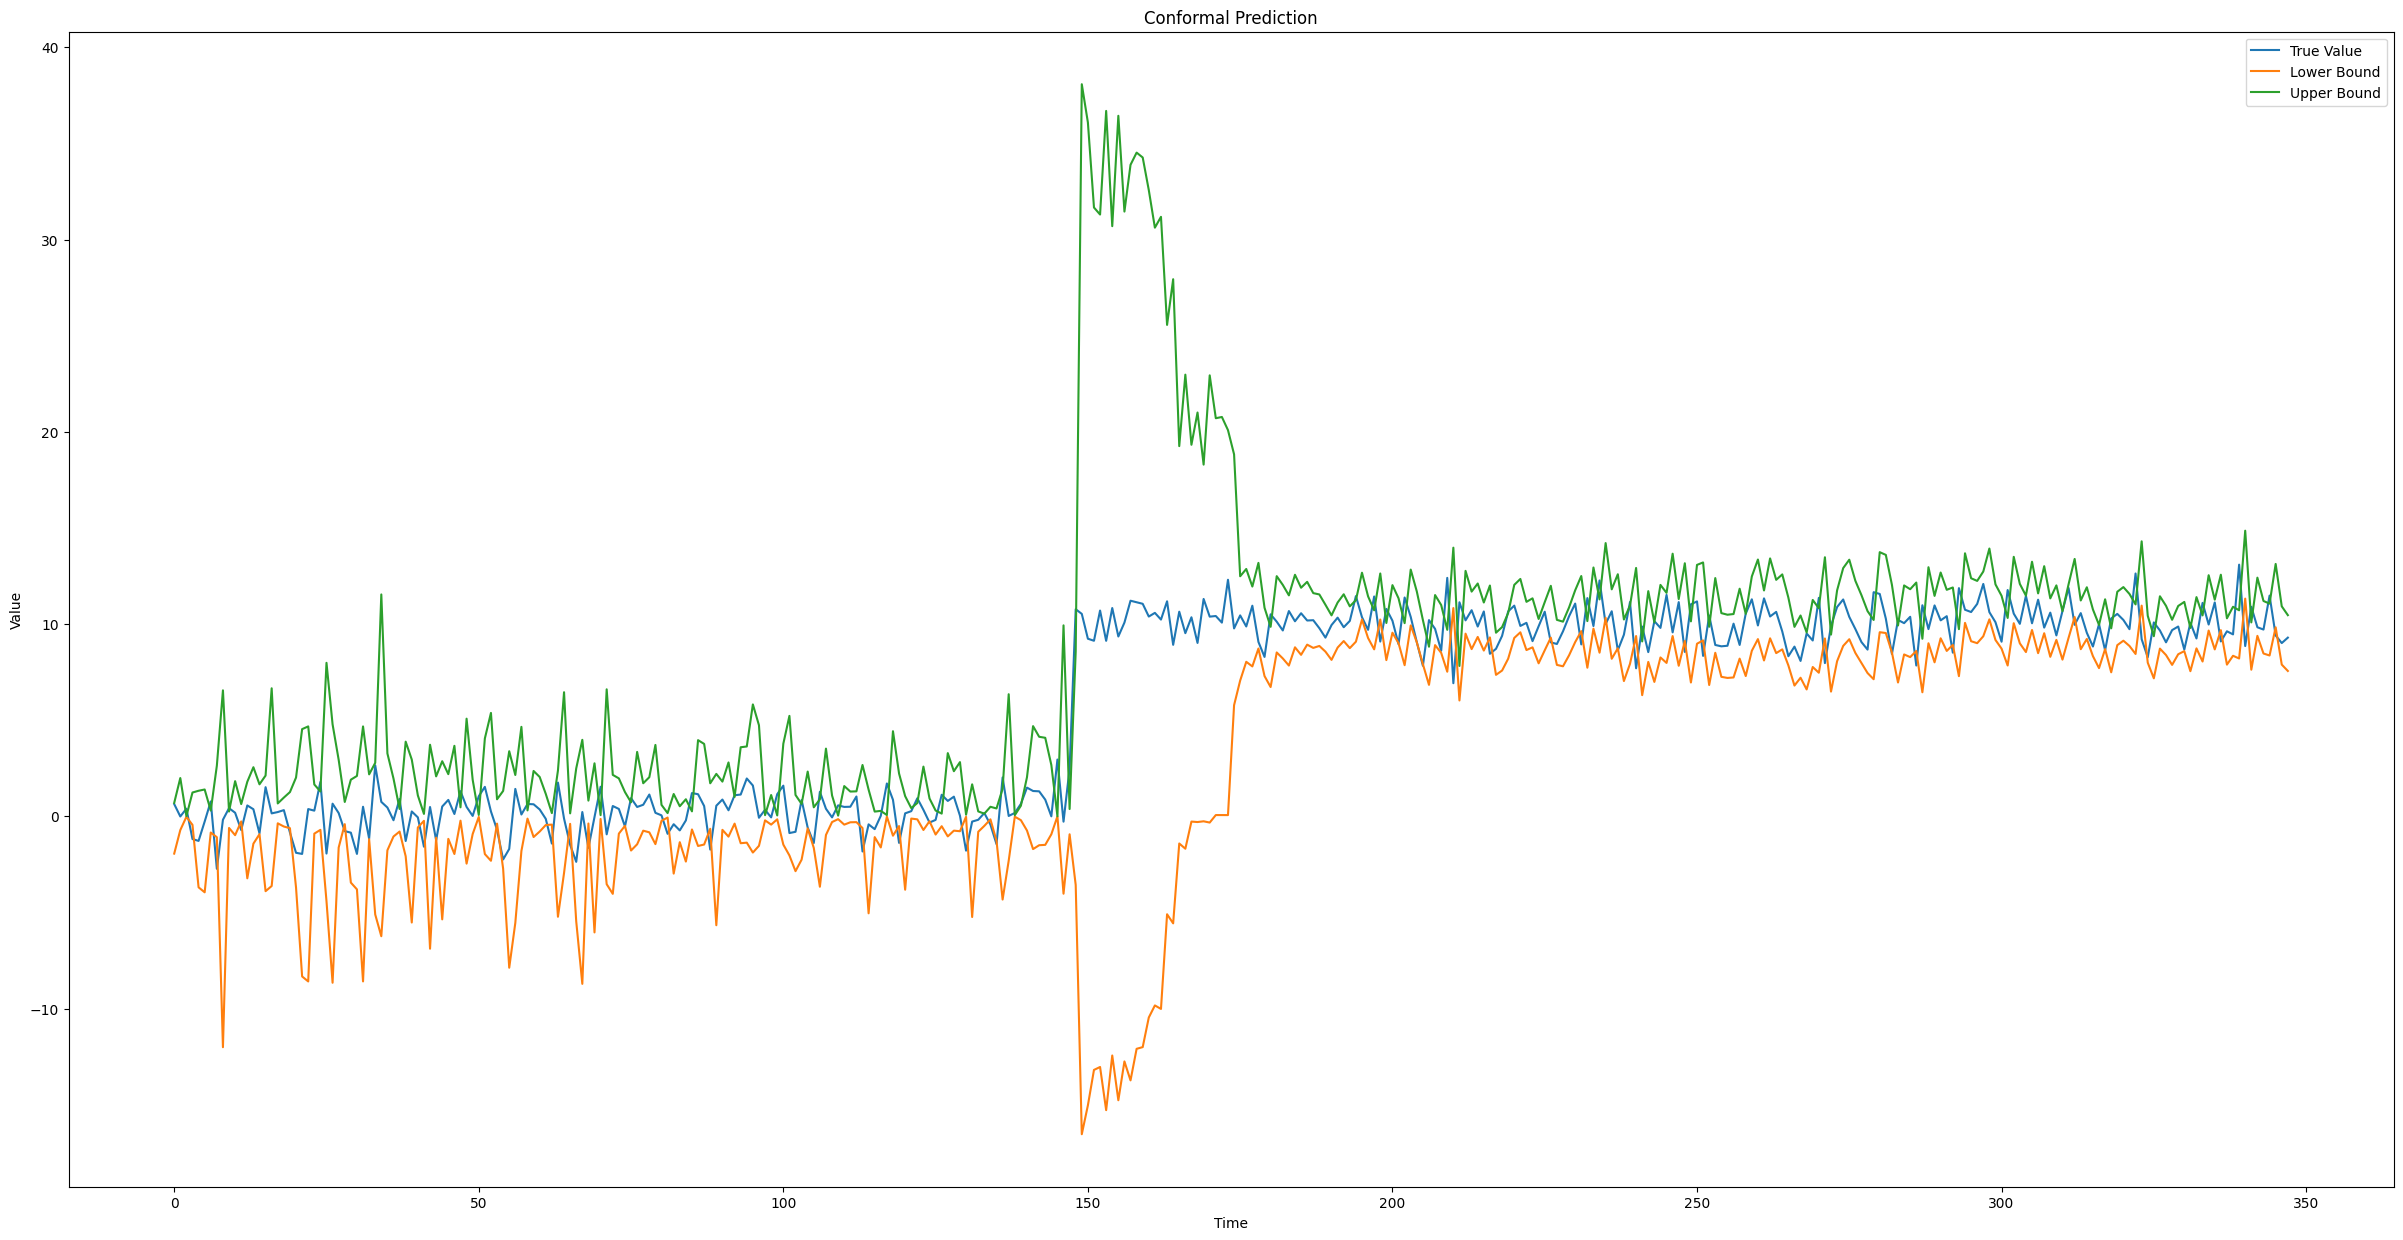

50
50
399 348 348


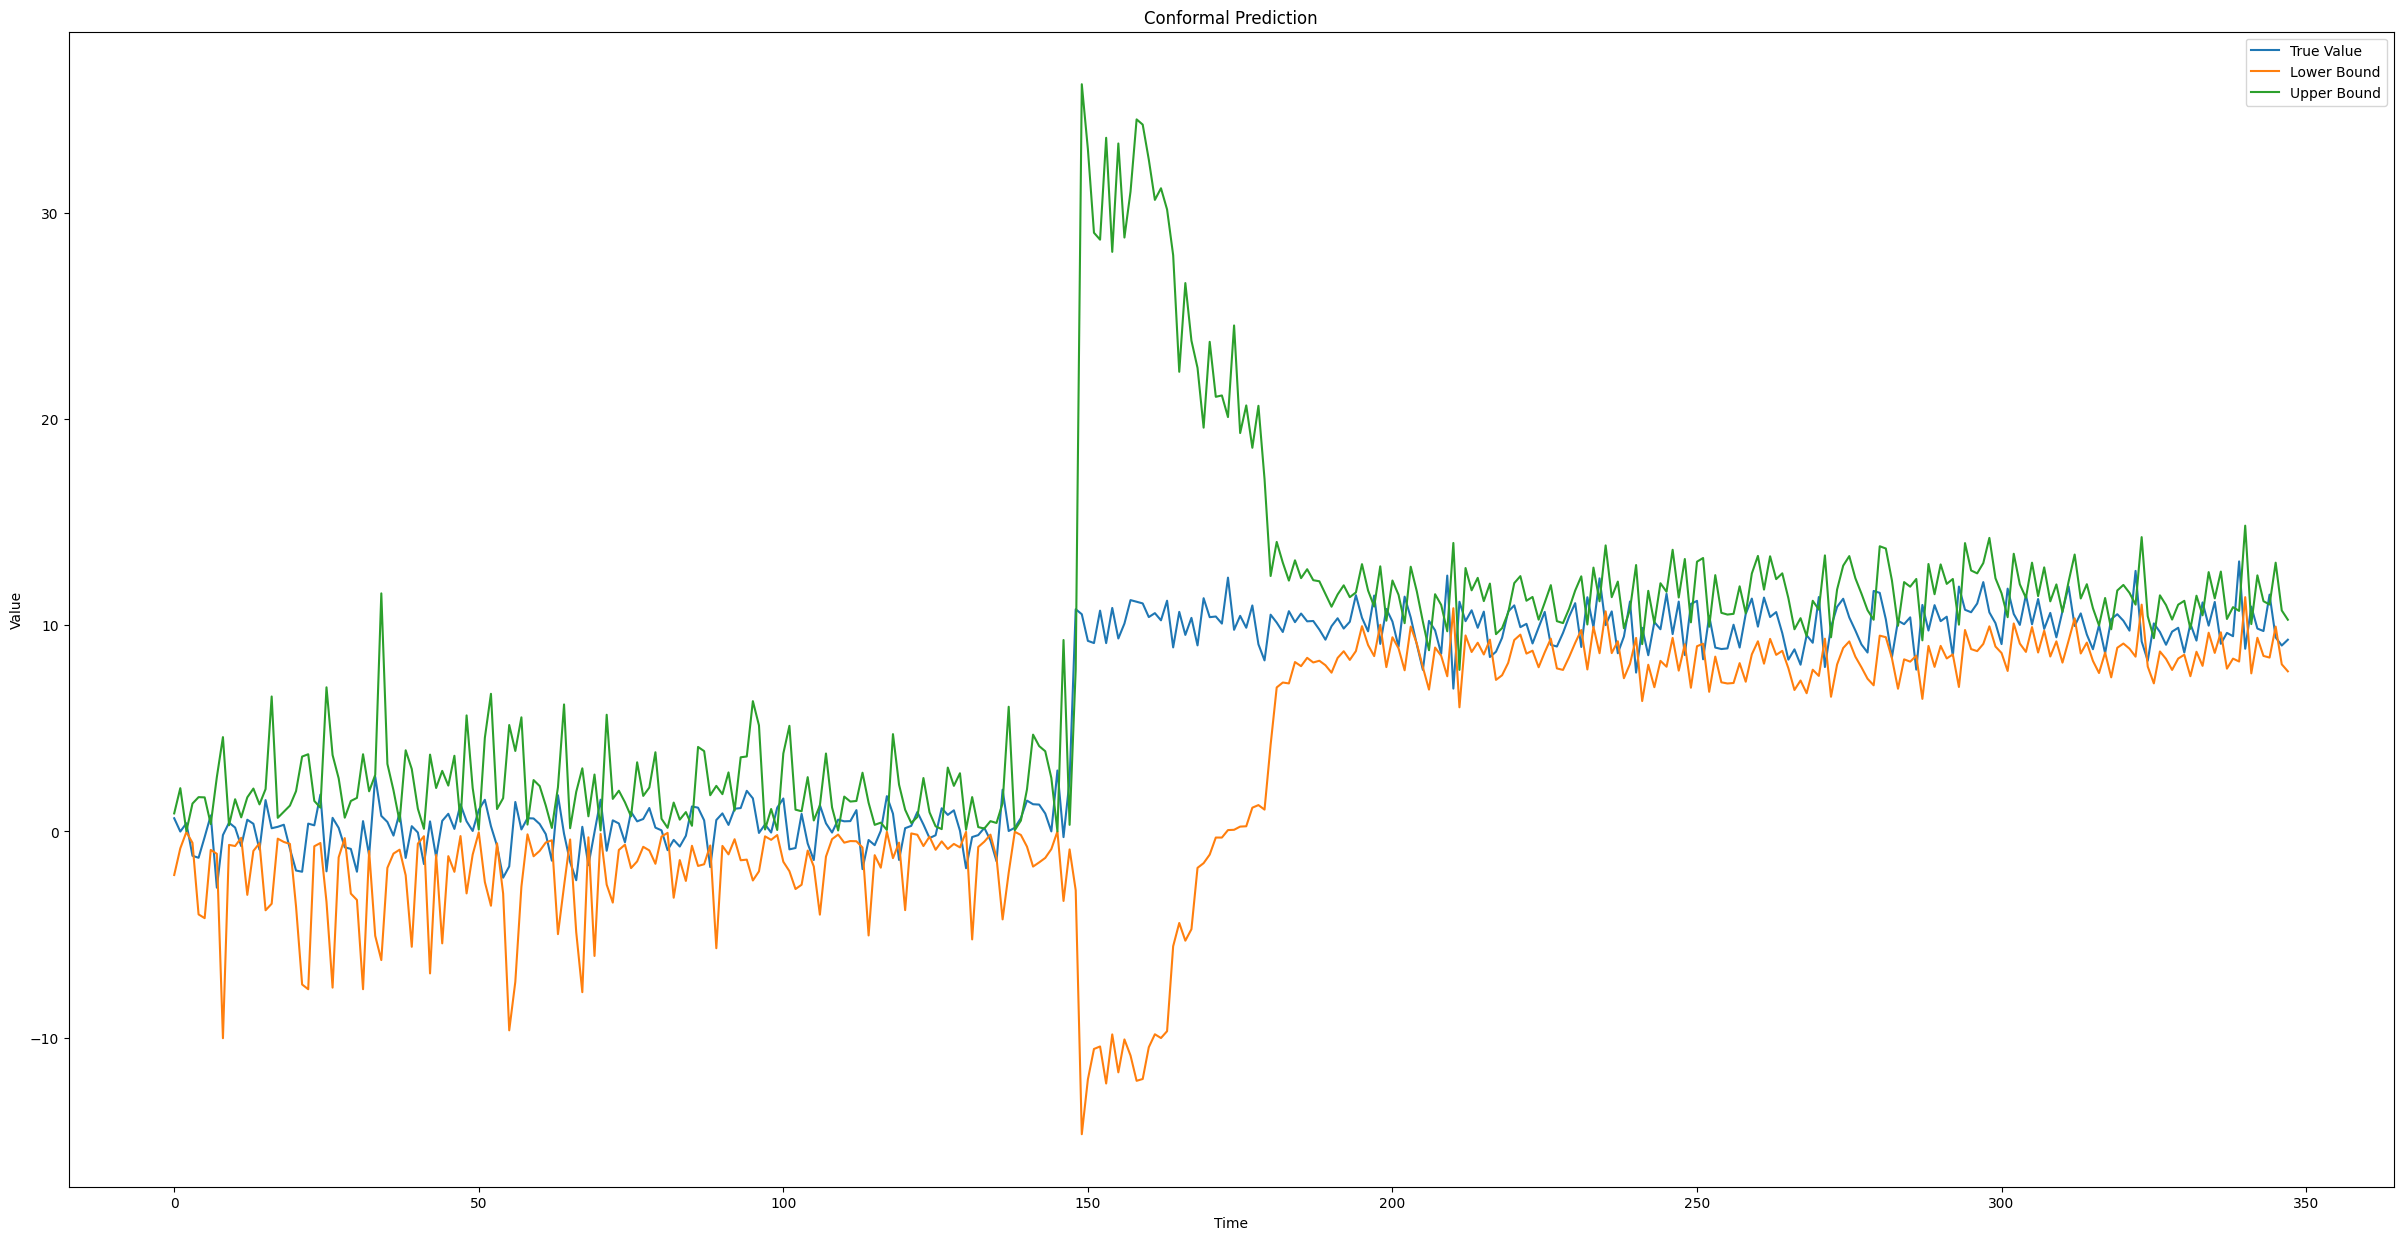

60
50
399 338 338


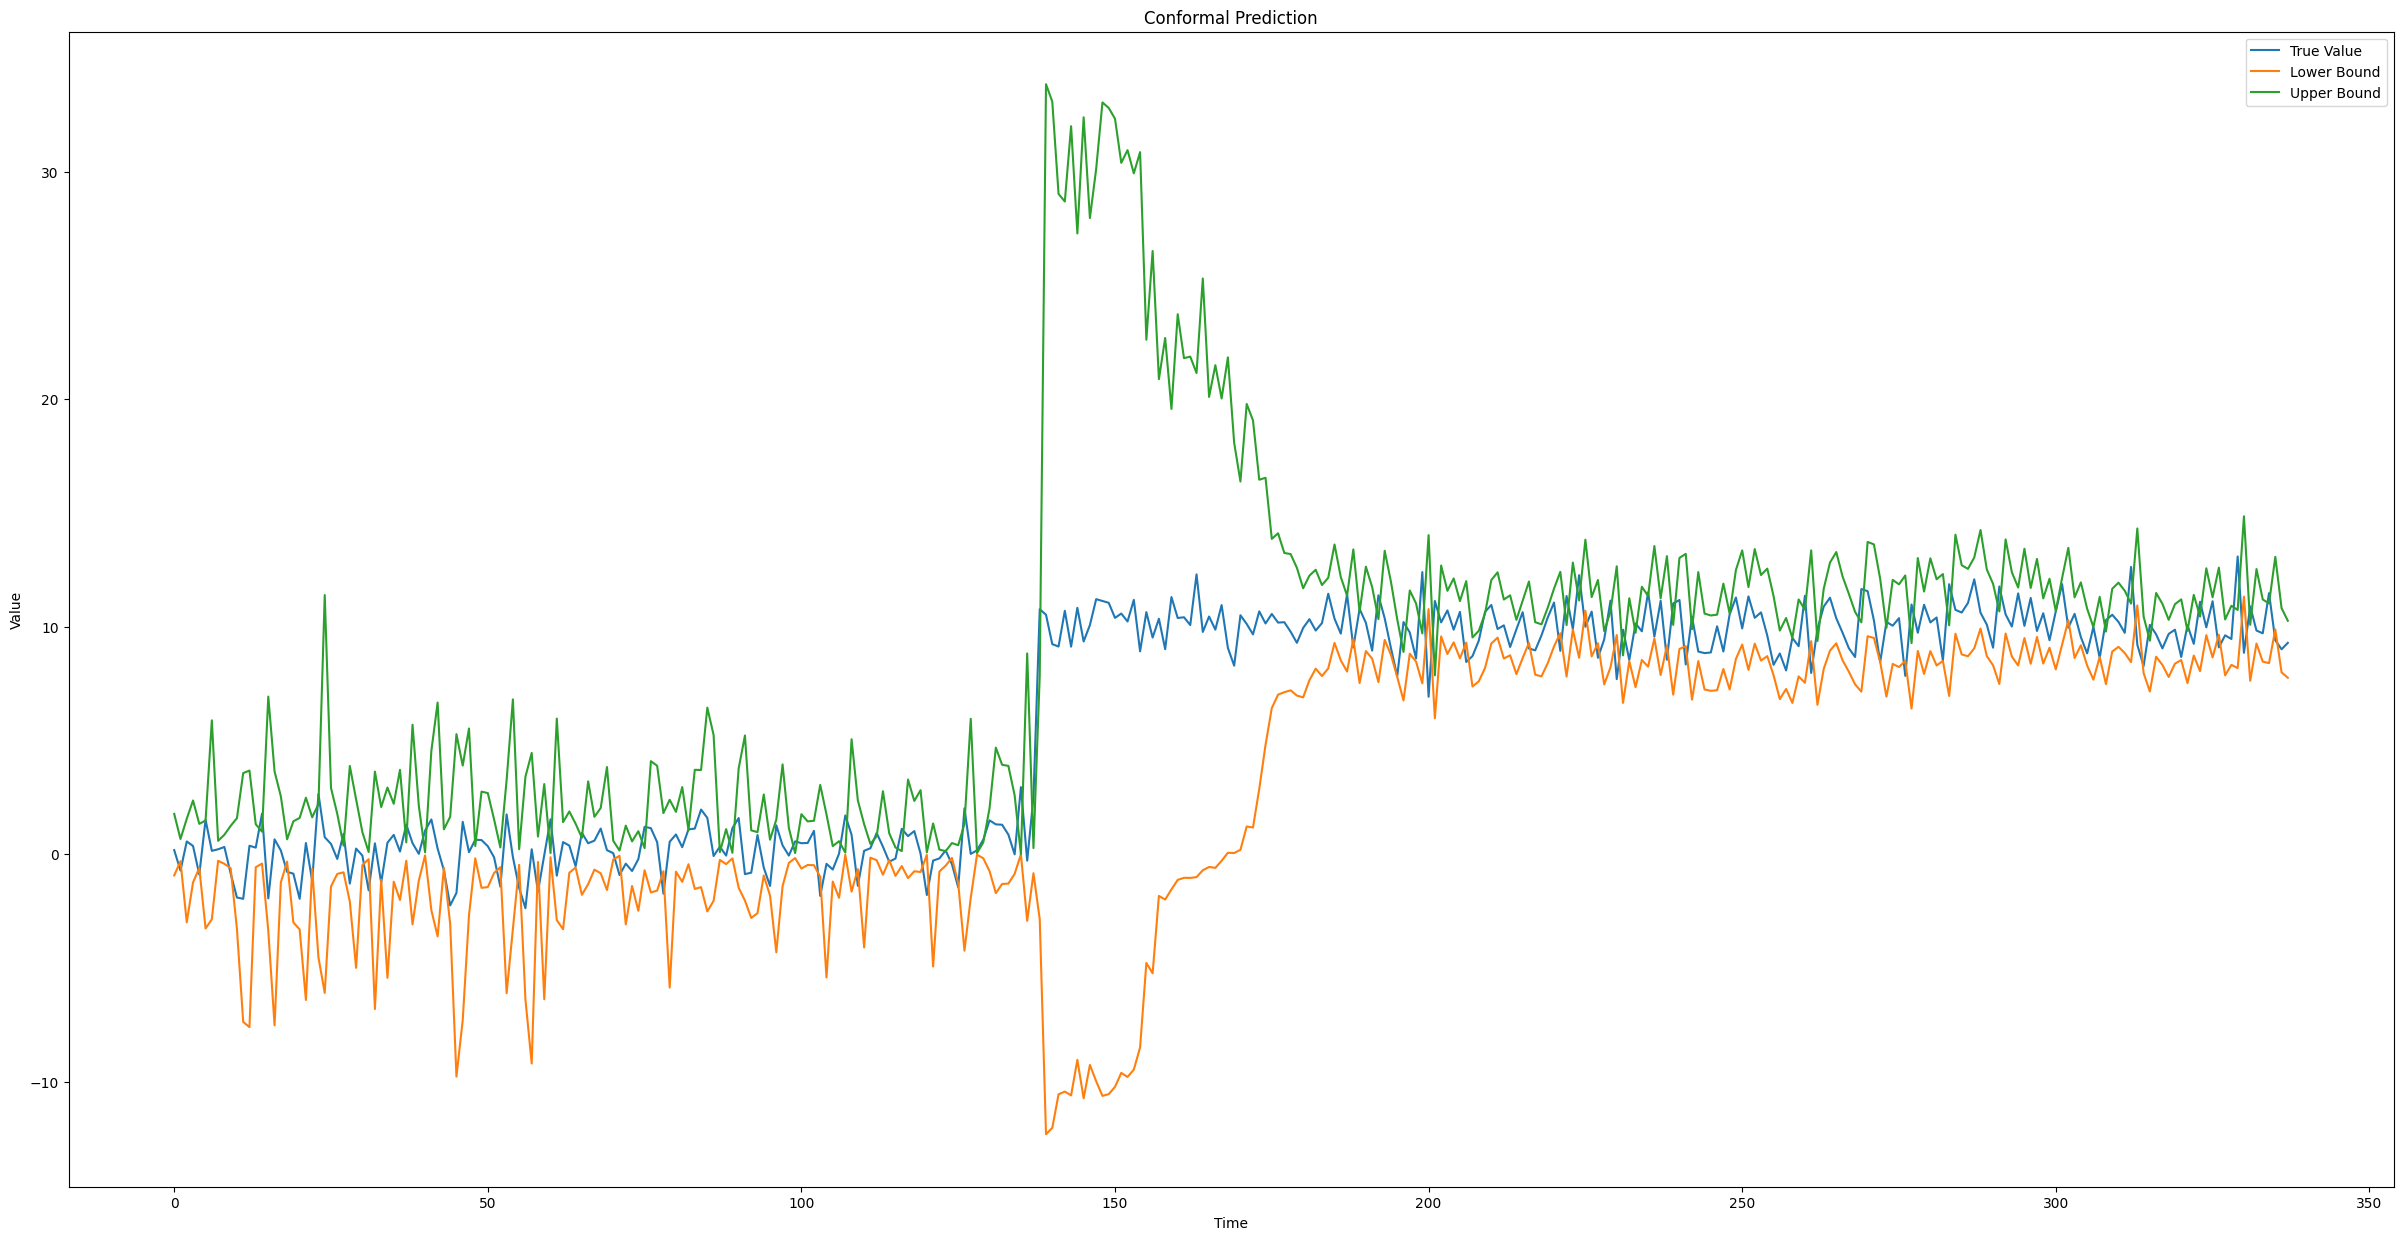

70
50
399 328 328


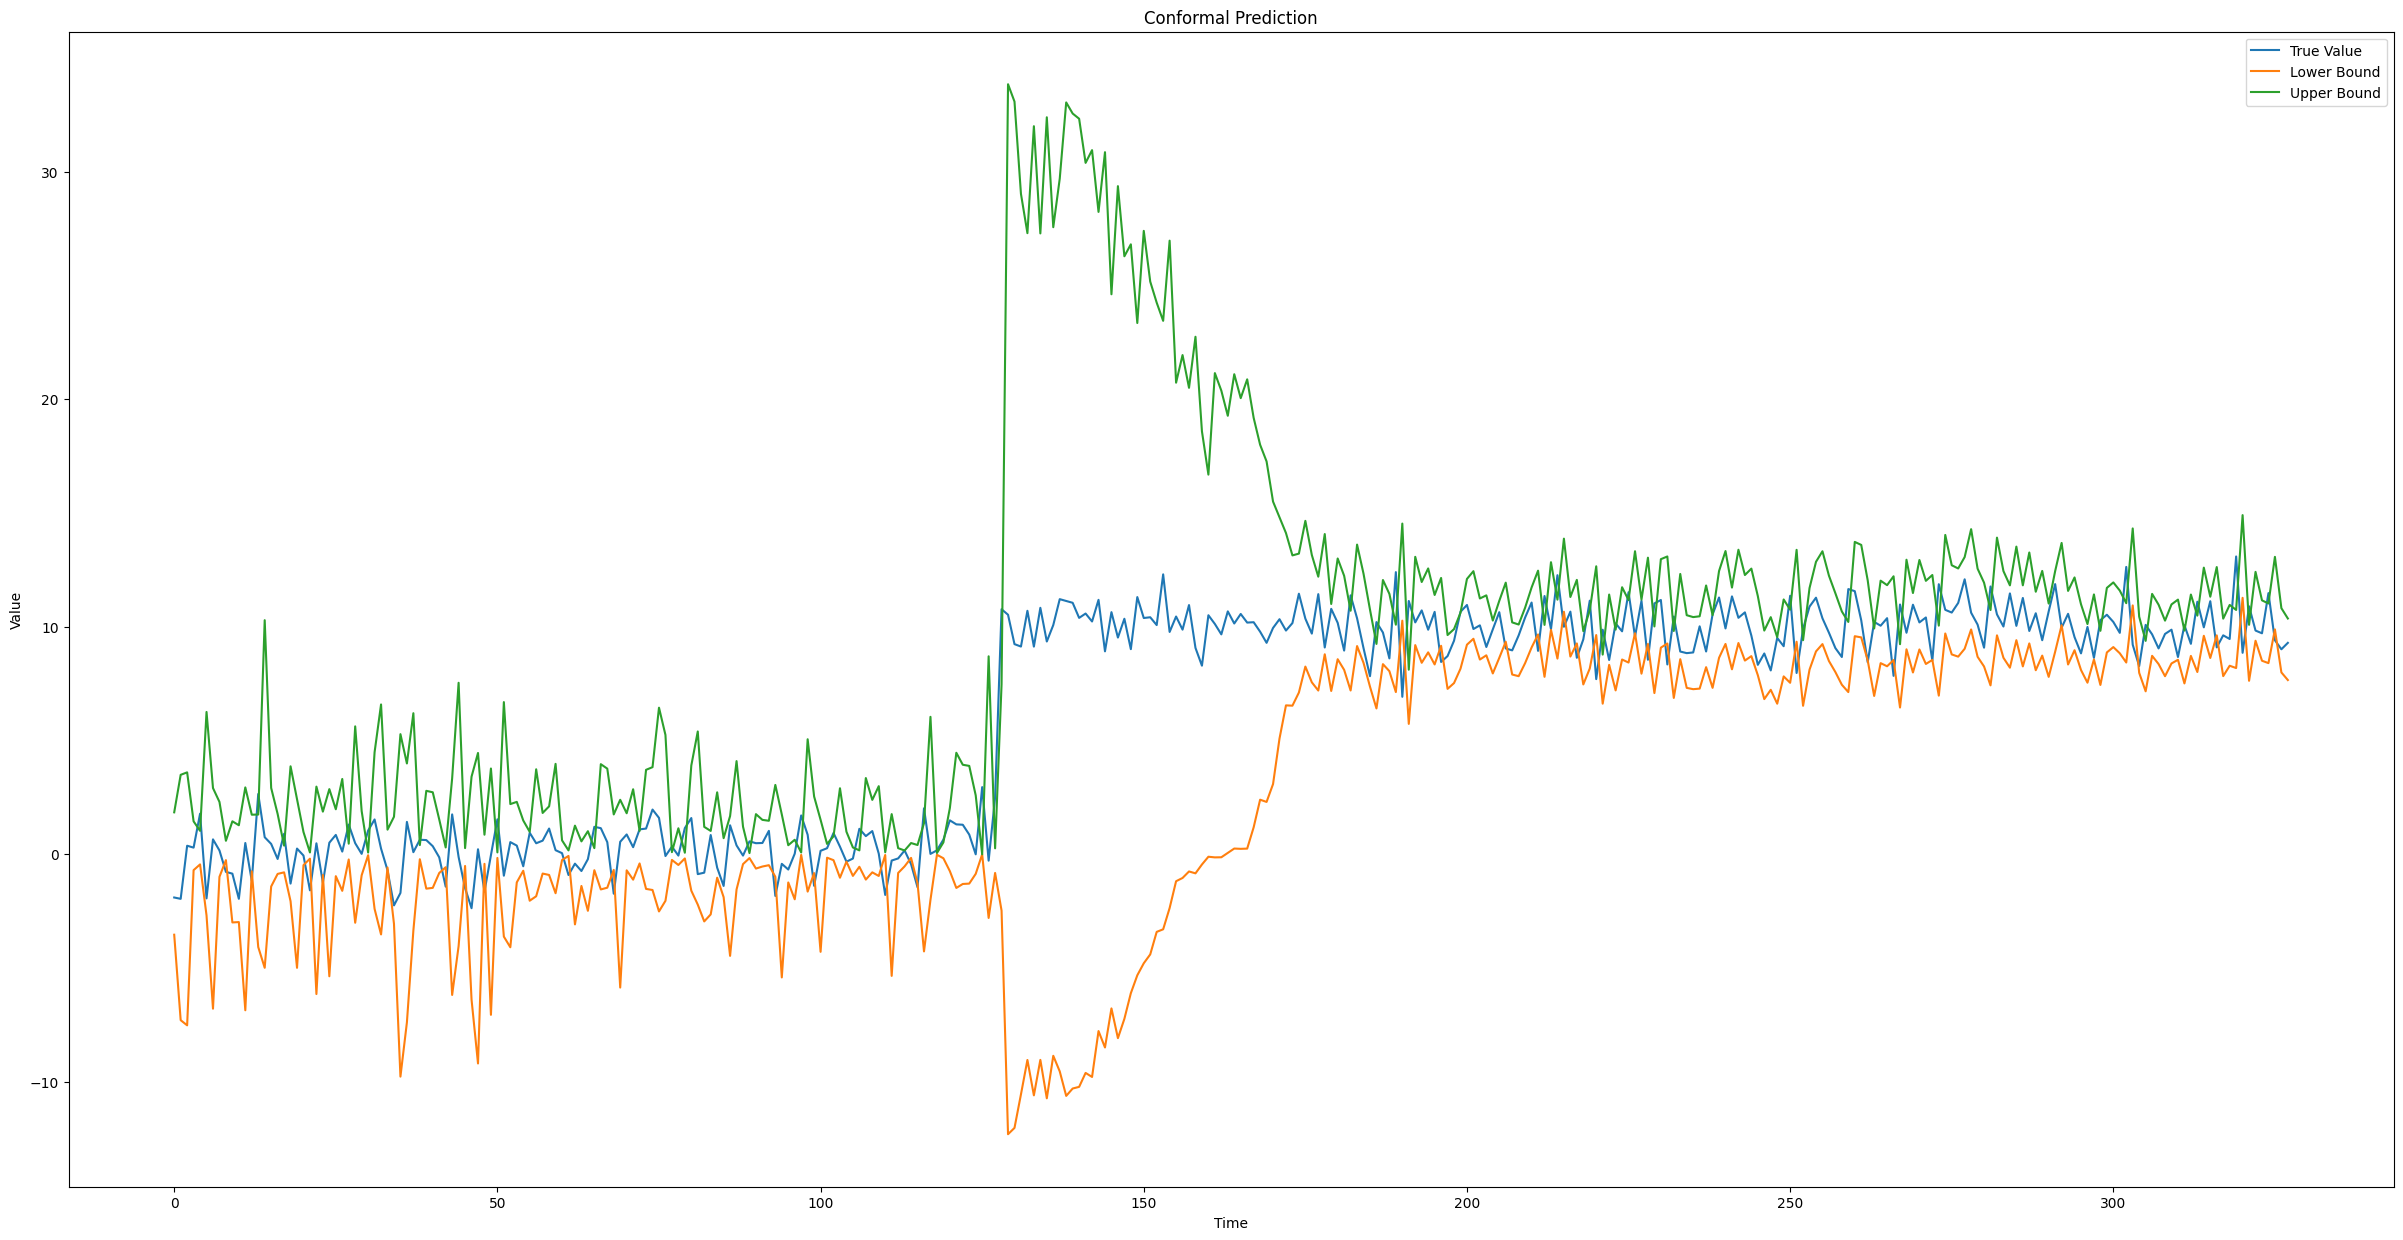

80
50
399 318 318


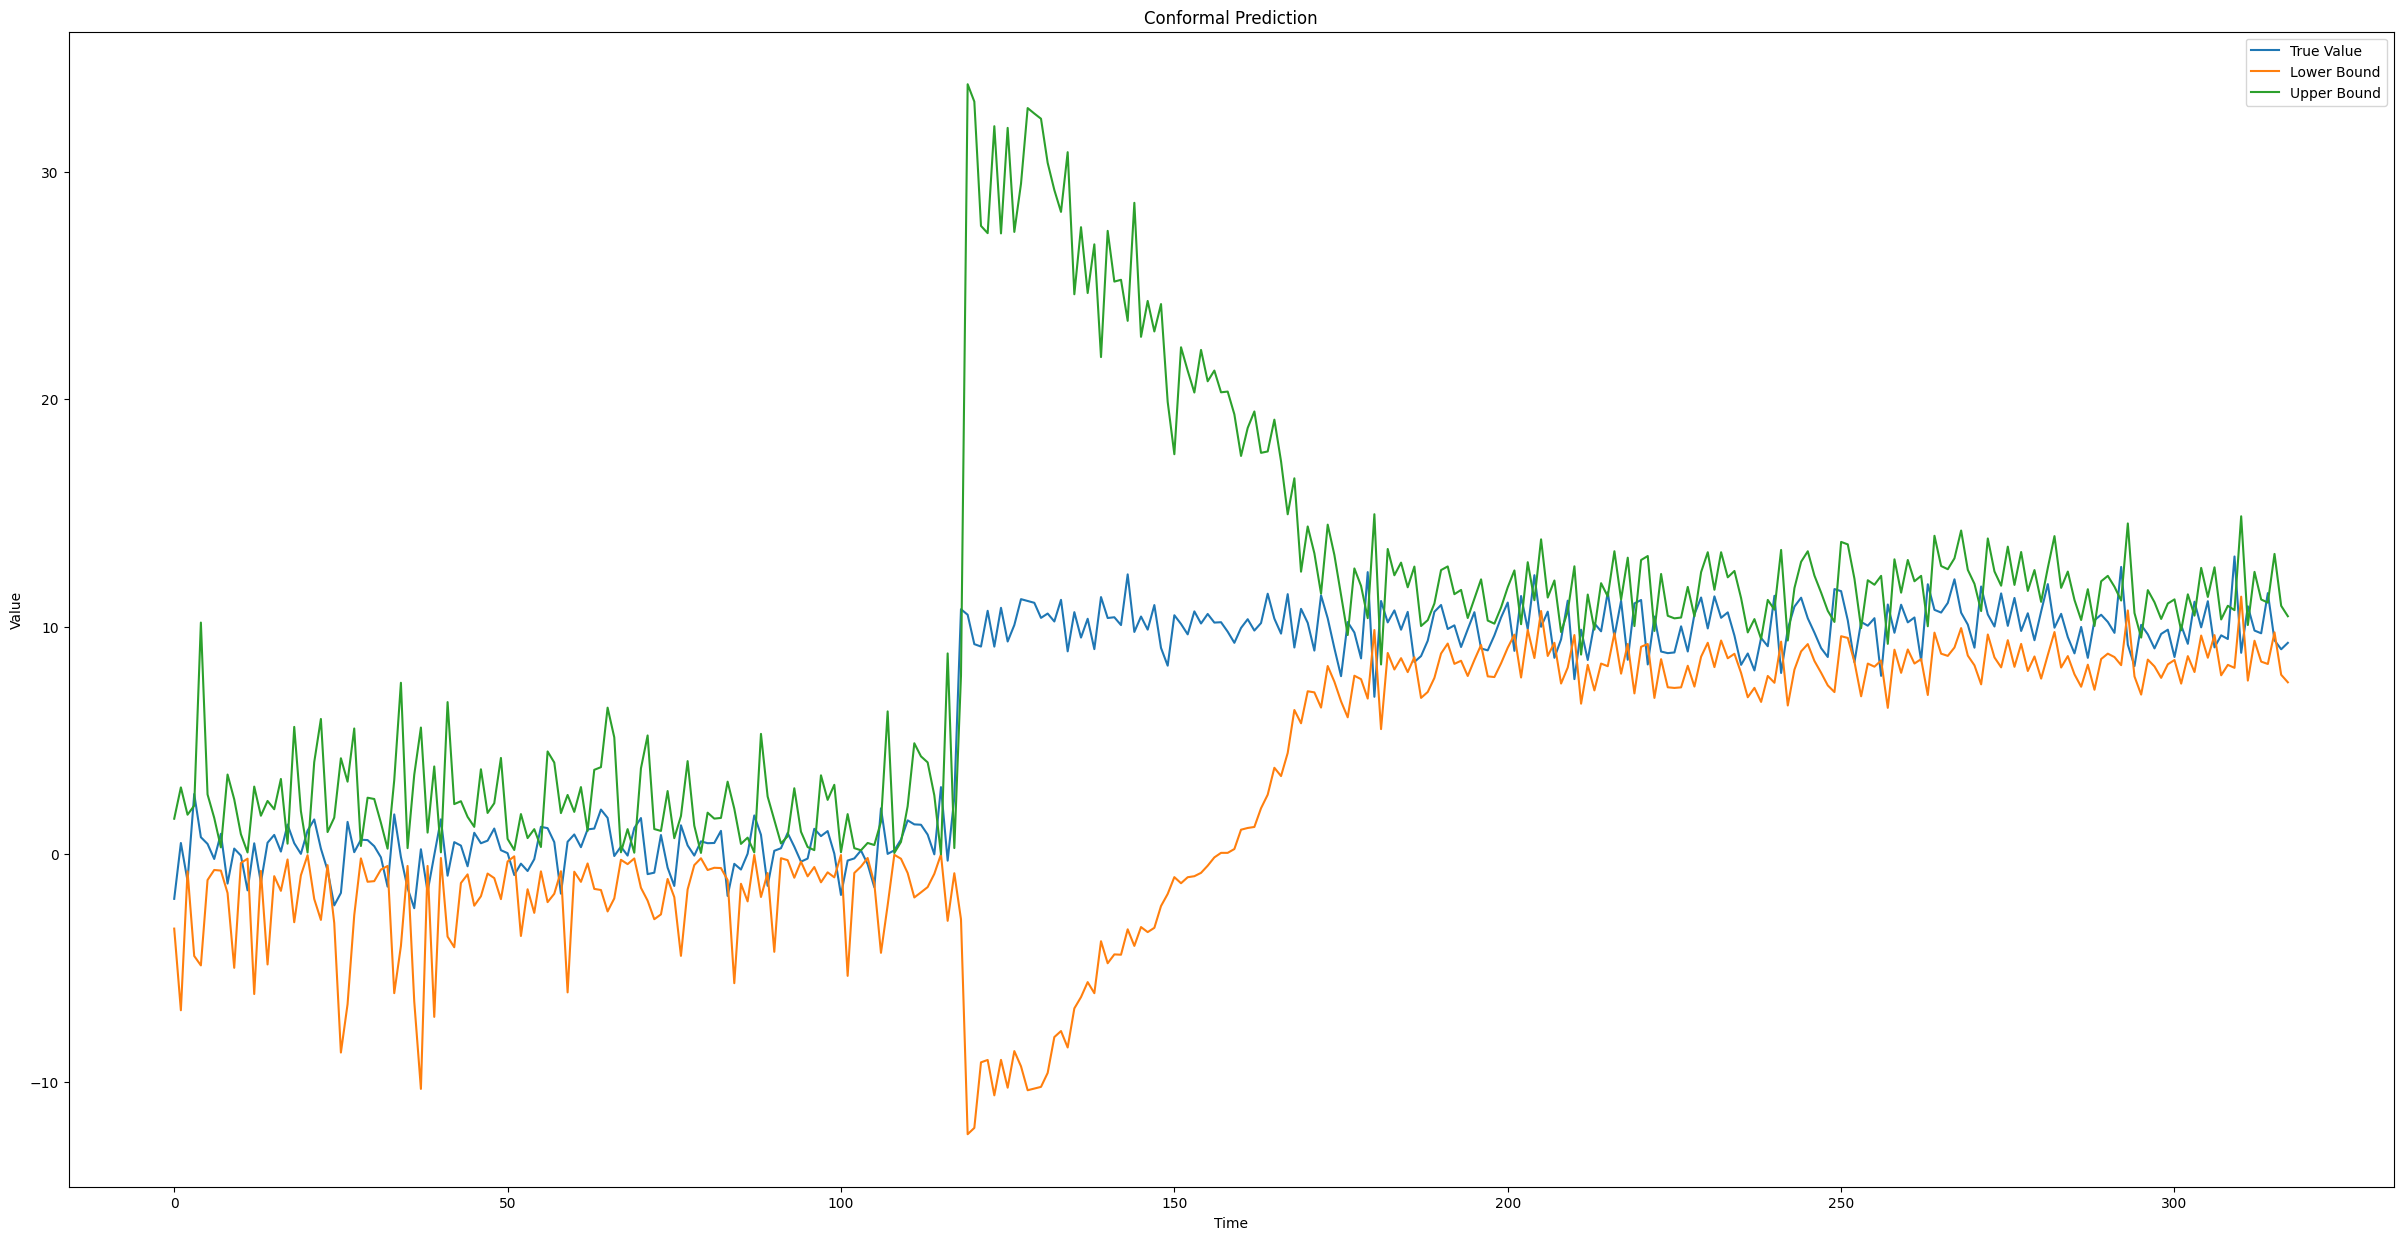

90
50
399 308 308


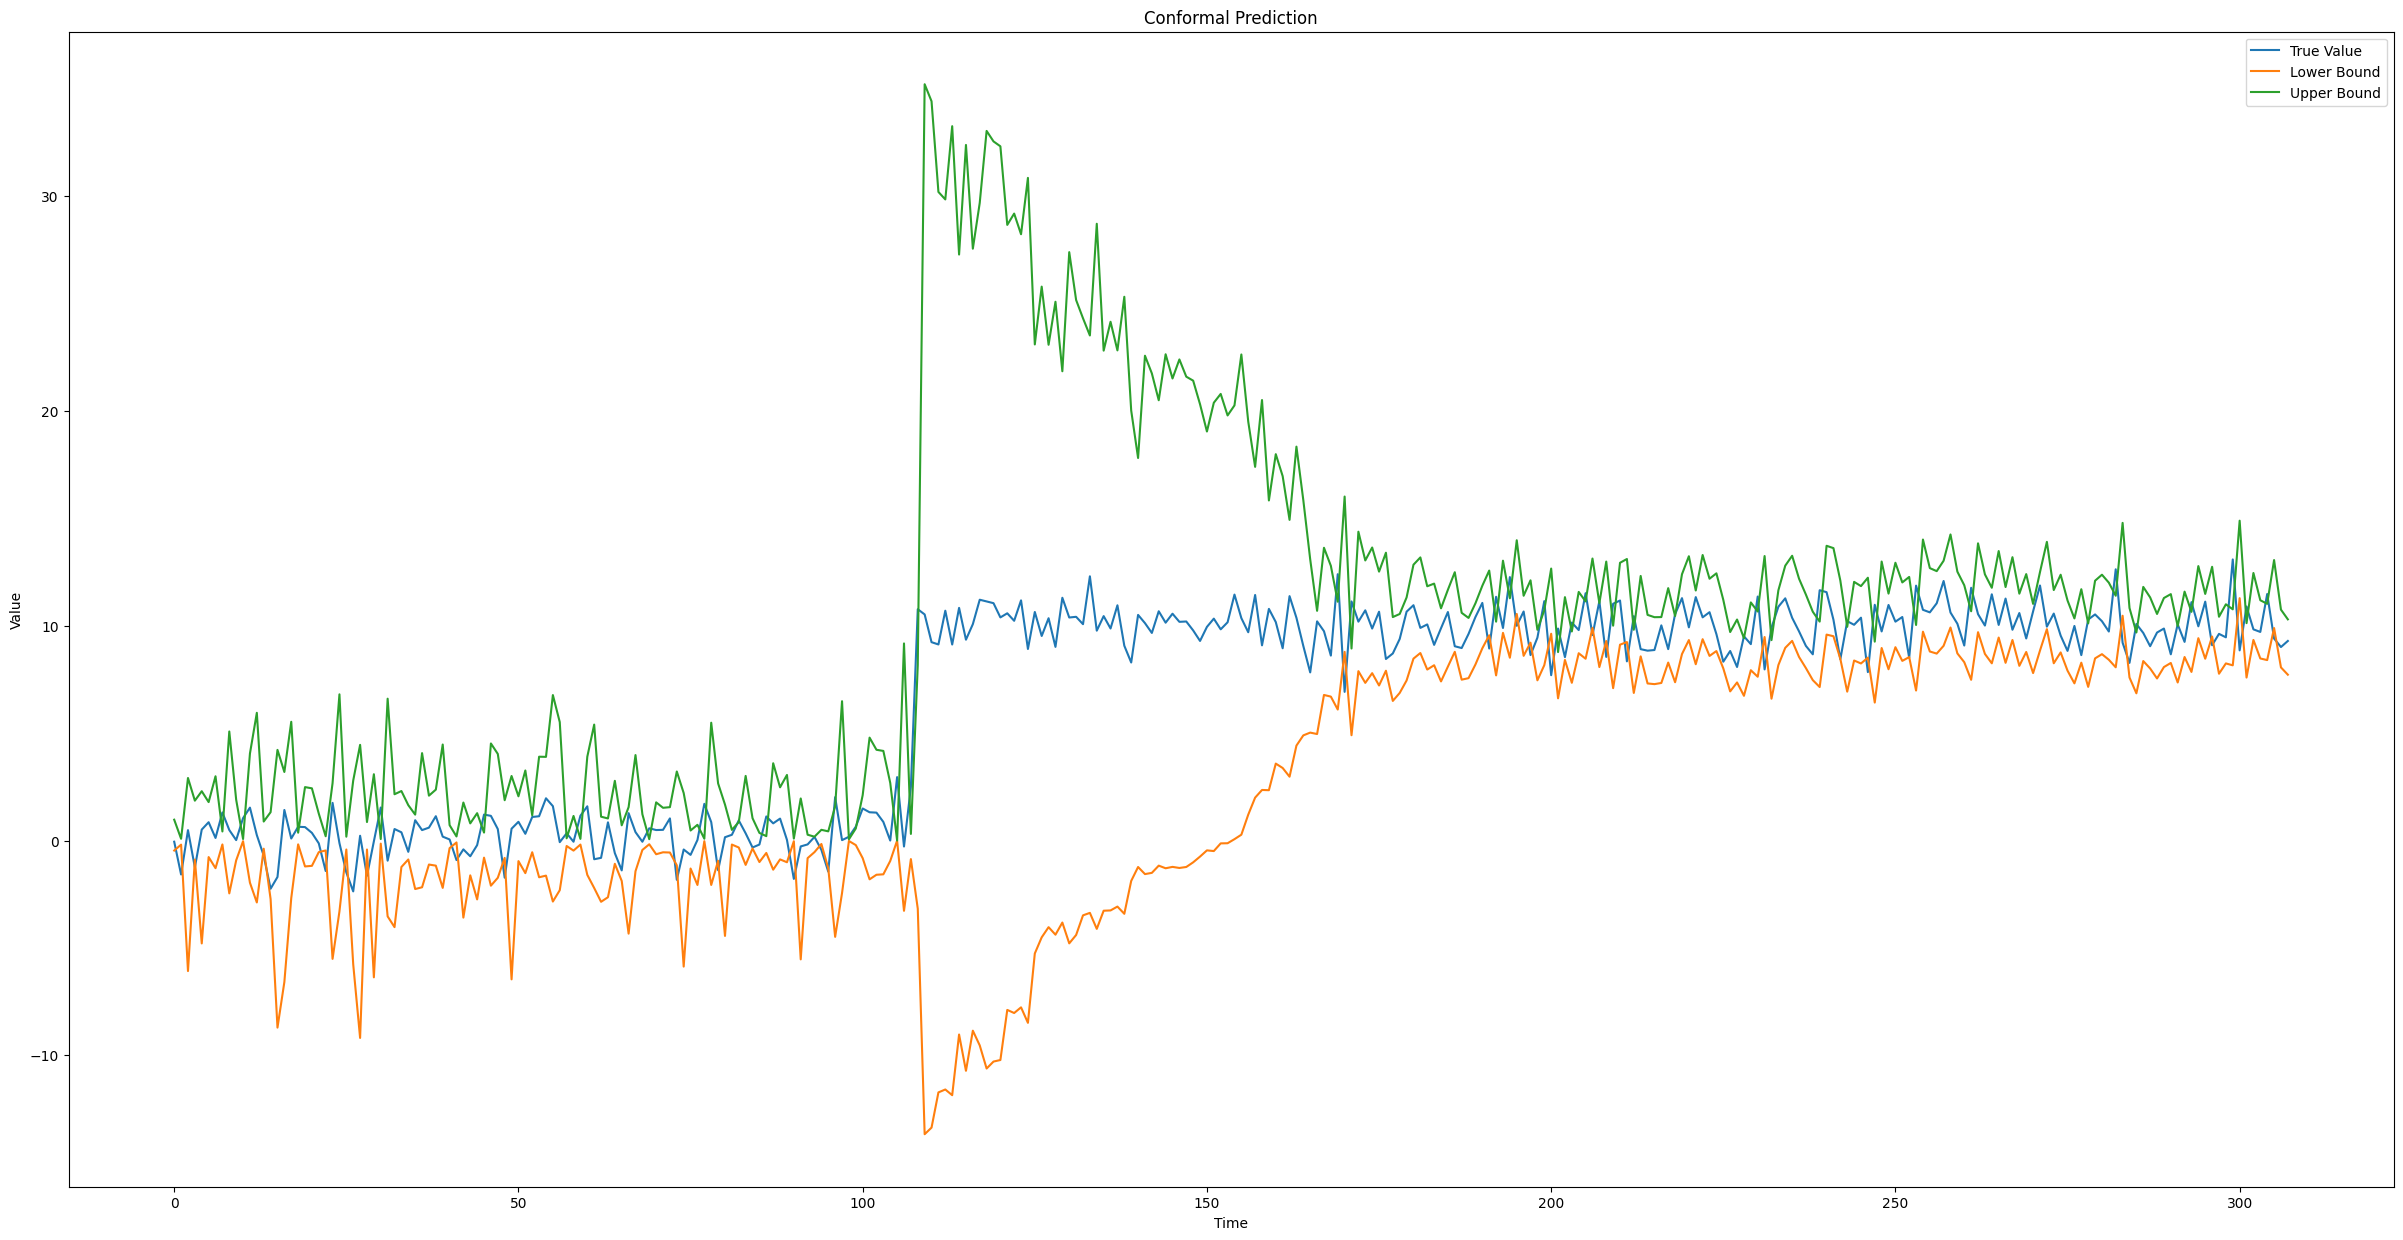

In [15]:
from numpy import random

jump_data = np.concatenate((np.random.normal(0, 1, 200), 10. + np.random.normal(0, 1, 200)))
x, y = jump_data[:-1], jump_data[1:]

lookbacks = range(10, 100, 10)
ACP = AdaptiveCP(0.3)

for lookback in lookbacks:
    print(lookback)
    window = ACP.NonAdaptive((x, y), lookback)
    print(window['interval_size'])
    ACP_plots.plot_y(window, y, lookback)

In [ ]:
from numpy import random

jump_data = np.concatenate((20.+np.random.normal(0, 1, 200), 10. + np.random.normal(0, 1, 200)))
x, y = jump_data[:-1], jump_data[1:]

lookbacks = range(10, 100, 10)
ACP = AdaptiveCP(0.3)

for lookback in lookbacks:
    print(lookback)
    window = ACP.NonAdaptive((x, y), lookback)
    print(window['interval_size'])
    ACP_plots.plot_y(window, y, lookback)